In [ ]:
!pip install -U datasets
!pip install fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [ ]:
!pip install diffusers transformers accelerate torch torchvision matplotlib pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
from datasets import load_dataset

# Load a subset of MagicBrush for demonstration
ds = load_dataset("osunlp/MagicBrush")

# Display dataset features and one example
# print(ds.features)
print(ds["train"][0])

Resolving data files:   0%|          | 0/51 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

{'img_id': '327726', 'turn_index': 1, 'source_img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500 at 0x185650AB070>, 'mask_img': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1024x1024 at 0x1856628A1D0>, 'instruction': 'change the table for a dog', 'target_img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x1856628AEC0>}


In [7]:
training_ds = ds["train"]
print(training_ds.features)
print(training_ds[0])

{'img_id': Value(dtype='string', id=None), 'turn_index': Value(dtype='int32', id=None), 'source_img': Image(mode=None, decode=True, id=None), 'mask_img': Image(mode=None, decode=True, id=None), 'instruction': Value(dtype='string', id=None), 'target_img': Image(mode=None, decode=True, id=None)}
{'img_id': '327726', 'turn_index': 1, 'source_img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500 at 0x185662F29B0>, 'mask_img': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1024x1024 at 0x18534374040>, 'instruction': 'change the table for a dog', 'target_img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x1856628AEC0>}


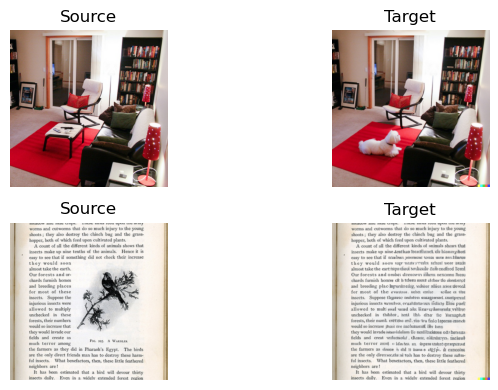

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
for i in range(2):
    src = training_ds[i]["source_img"]  # Already a PIL Image
    tgt = training_ds[i]["target_img"]  # Already a PIL Image
    plt.subplot(2, 2, 2*i+1)
    plt.imshow(src)
    plt.title("Source")
    plt.axis("off")
    plt.subplot(2, 2, 2*i+2)
    plt.imshow(tgt)
    plt.title("Target")
    plt.axis("off")

plt.tight_layout()
plt.show()

-----------------------------------------------------------------------Implementing-----------------------------------------------------------------

In [1]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from tqdm import tqdm



In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 3
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
LAMBDA_IMG = 1.0

In [3]:
# Dataset Dataloader
class ImageCaptionDataset(Dataset):
    def __init__(self, data_set, transform=None):
        """
        data_list: dataset read from MagicBrush dataset (to access image: data_set[i]["source_img"]; data_set[i]["target_img"]. To access text: data_set[i]["instruction"])
        transform: image transform
        """
        self.data_set = data_set
        self.transform = transform

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        image = self.data_set[idx]["source_img"]
        caption = self.data_set[idx]["instruction"]
        target_img = self.data_set[idx]["target_img"]

        # Convert RGBA to RGB if necessary
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        if target_img.mode == 'RGBA':
            target_img = target_img.convert('RGB')

        if self.transform:
            image = self.transform(image)
            target_img = self.transform(target_img)

        return {"image": image, "text": caption, "target": target_img}

In [4]:
# Data Augmentation
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),])

In [9]:
dataset = ImageCaptionDataset(training_ds, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

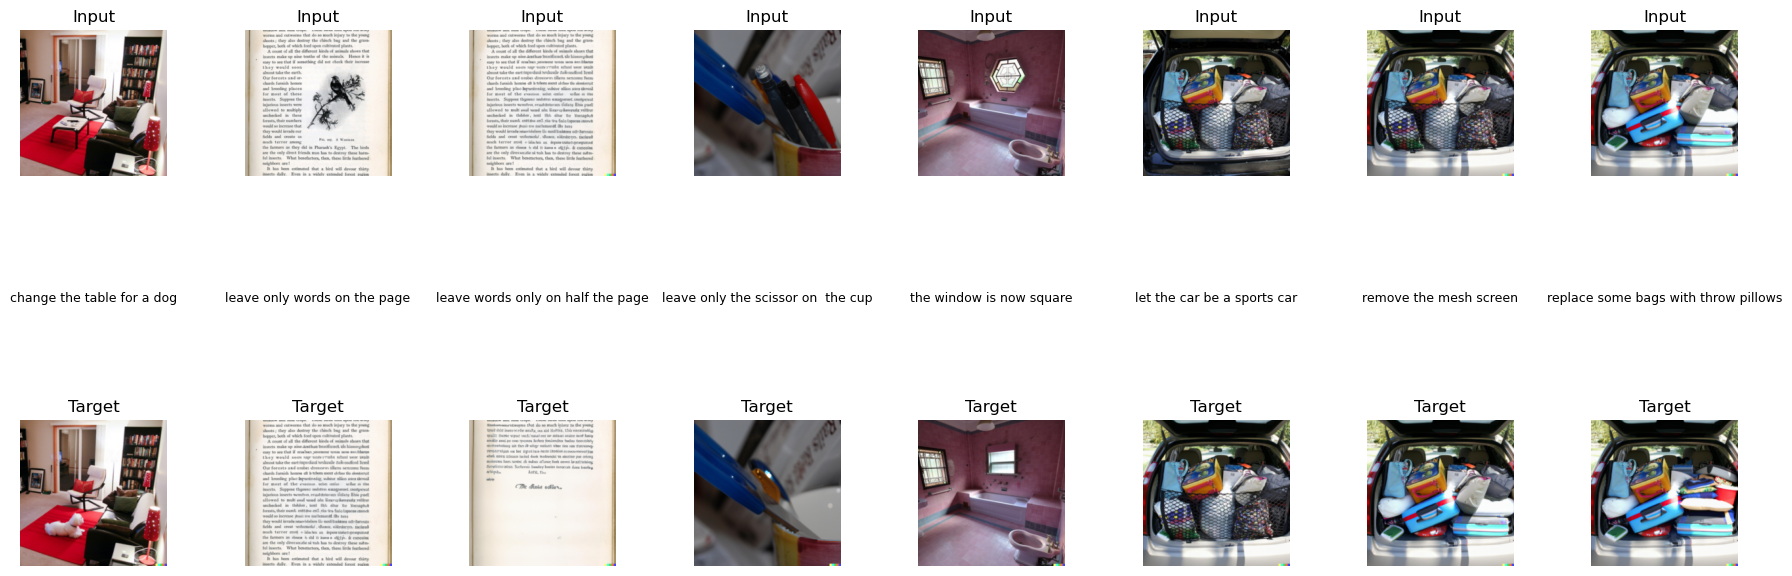

In [52]:
# this is to visualize batched data
def show_triplet_batch(batch):
    images = batch["image"]
    captions = batch["text"]
    target_images = batch["target"]

    plt.figure(figsize=(18, 6))
    for i in range(len(images)):
        input_img_np = images[i].permute(1, 2, 0).numpy()
        target_img_np = target_images[i].permute(1, 2, 0).numpy()
        # print(input_img_np.shape)
        # print(target_img_np.shape)

        # Original image
        plt.subplot(3, len(images), i + 1)
        plt.imshow(input_img_np)
        plt.title("Input")
        plt.axis("off")

        # Caption
        plt.subplot(3, len(images), len(images) + i + 1)
        plt.text(0.5, 0.5, captions[i], wrap=True, ha='center', va='center', fontsize=9)
        plt.gca().set_frame_on(False)
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)

        # Target image
        plt.subplot(3, len(images), 2 * len(images) + i + 1)
        plt.imshow(target_img_np)
        plt.title("Target")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize one batch
for batch in dataloader:
    show_triplet_batch(batch)
    break


---------------------------------------------------------------------------until here---------------------------------------------------------------------

---------------------------------------------------------------get img embeds and text embeds--------------------------------------------------------------

In [10]:
class EmbedMapper(nn.Module):
    def __init__(self, dim=512):  # CLIP base outputs 512-d embeddings
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim * 2, dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
        )

    def forward(self, z_img, z_txt):
        z_cat = torch.cat([z_img, z_txt], dim=1)
        return self.fc(z_cat)  # z

In [11]:
z_img = torch.randn(BATCH_SIZE, 512)
z_txt = torch.randn(BATCH_SIZE, 512)

model = EmbedMapper(dim=512)
z_out = model(z_img, z_txt)

print(f"Input image embedding shape: {z_img.shape}")
print(f"Input text embedding shape:  {z_txt.shape}")
print(f"Output shape (z'):            {z_out.shape}")

Input image embedding shape: torch.Size([8, 512])
Input text embedding shape:  torch.Size([8, 512])
Output shape (z'):            torch.Size([8, 512])


In [12]:
class Decoder(nn.Module):
    def __init__(self, z_dim=512, out_channels=3):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 7 * 7 * 512),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, 7, 7)),                   # (B, 512, 7, 7)
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # (B, 256, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # (B, 128, 28, 28)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # (B, 64, 56, 56)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),    # (B, 32, 112, 112)
            nn.ReLU(),
            nn.ConvTranspose2d(32, out_channels, 4, stride=2, padding=1),  # (B, 3, 224, 224)
            nn.Sigmoid()  # Output in [0, 1]
        )

    def forward(self, z, original_img):
        """
        Args:
            z: latent vector (B, z_dim)
            original_img: image tensor in [0, 1], shape (B, 3, 224, 224)

        Returns:
            Modified image, shape (B, 3, 224, 224), in [0, 1]
        """
        pred = self.fc(z)
        pred = self.decoder(pred)

        # Optional skip connection: ensure result is still in [0, 1]
        output = original_img + pred
        output = torch.clamp(output, 0.0, 1.0)
        return output

In [13]:
z = torch.randn(BATCH_SIZE, 512)
original_img = torch.rand(BATCH_SIZE, 3, 224, 224)

decoder = Decoder(z_dim=512)
output = decoder(z, original_img)

print(f"Input latent vector shape: {z.shape}")
print(f"Output image shape:        {output.shape}")

Input latent vector shape: torch.Size([8, 512])
Output image shape:        torch.Size([8, 3, 224, 224])


In [17]:
def train(model_mapper, model_decoder, clip_model, clip_processor, dataloader, device=DEVICE, epochs=EPOCH, lambda_img=LAMBDA_IMG, lr=LEARNING_RATE, batch_size=BATCH_SIZE):
    model_mapper.to(device)
    model_decoder.to(device)
    clip_model.to(device)
    clip_model.eval()  # Freeze CLIP
    

    optimizer = torch.optim.Adam(list(model_mapper.parameters()) + list(model_decoder.parameters()), lr=lr)
    loss_latent = nn.CosineEmbeddingLoss()
    loss_img = nn.MSELoss()

    for epoch in range(epochs):
        model_mapper.train()
        model_decoder.train()
        total_loss = 0.0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            image_src = batch["image"].to(device)
            image_tgt = batch["target"].to(device)
            text_prompt = batch["text"]
            

            # --------- Get CLIP embeddings ---------
            with torch.no_grad():
                inputs_src = clip_processor(images=image_src, return_tensors="pt").to(device)
                inputs_tgt = clip_processor(images=image_tgt, return_tensors="pt").to(device)
                inputs_txt = clip_processor(text=text_prompt, return_tensors="pt", padding=True, truncation=True).to(device)

                z_src = clip_model.get_image_features(**inputs_src)
                z_tgt = clip_model.get_image_features(**inputs_tgt)
                z_txt = clip_model.get_text_features(**inputs_txt)

                z_src = z_src / z_src.norm(dim=1, keepdim=True)
                z_tgt = z_tgt / z_tgt.norm(dim=1, keepdim=True)
                z_txt = z_txt / z_txt.norm(dim=1, keepdim=True)

            # --------- Forward Pass ---------
            
            z_pred = model_mapper(z_src, z_txt)
            pred_img = model_decoder(z_tgt, image_src)

            # --------- Compute Loss ---------
            cos_target = torch.ones(z_pred.size(0)).to(device)
            loss_embed = loss_latent(z_pred, z_tgt, cos_target)
            loss_recon = loss_img(pred_img, image_tgt)
            loss = loss_embed + lambda_img * loss_recon

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

In [18]:
model_mapper = EmbedMapper()
model_decoder = Decoder()
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [19]:
train(model_mapper, model_decoder, clip_model, clip_processor, dataloader)

Epoch 1/3:   0%|          | 4/1101 [00:10<46:58,  2.57s/it]


KeyboardInterrupt: 

In [ ]:


model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

all_image_embeds = []
all_text_embeds = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        # Move images and texts to device
        images = batch["image"]
        texts = batch["text"]
        # Use processor to prepare inputs for CLIP
        inputs = processor(
            images=images,
            text=texts,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        # Forward pass
        outputs = model(**inputs)

        # Extract embeddings
        image_embeds = outputs.image_embeds  # shape: (batch_size, hidden_dim)
        text_embeds = outputs.text_embeds    # shape: (batch_size, hidden_dim)

        # Save to list (move to CPU to avoid GPU memory leak)
        all_image_embeds.append(image_embeds.cpu())
        all_text_embeds.append(text_embeds.cpu())

# Concatenate all embeddings
all_image_embeds = torch.cat(all_image_embeds, dim=0)  # shape: (N, D)
all_text_embeds = torch.cat(all_text_embeds, dim=0)    # shape: (N, D)

print("Image embeddings shape:", all_image_embeds.shape)
print("Text embeddings shape:", all_text_embeds.shape)

100%|██████████| 1101/1101 [33:44<00:00,  1.84s/it]

Image embeddings shape: torch.Size([8807, 512])
Text embeddings shape: torch.Size([8807, 512])


In [14]:
print(len(training_ds))

8807


---------------------------------------------------------------------------until here--------------------------------------------------------------------------

In [ ]:
# difussion model, consider later
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import torch

model_id = "vinesmsuic/magicbrush-jul7"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()

model_index.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.58k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--vinesmsuic--magicbrush-jul7/snapshots/d75a9f18439f67dbdc0ab113036f491ce2256c53/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--vinesmsuic--magicbrush-jul7/snapshots/d75a9f18439f67dbdc0ab113036f491ce2256c53/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--vinesmsuic--magicbrush-jul7/snapshots/d75a9f18439f67dbdc0ab113036f491ce2256c53/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--vinesmsuic--magicbrush-jul7/snapshots/d75a9f18439f67dbdc0ab113036f491ce2256c53/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:30: FutureWarn

In [ ]:
from PIL import Image


  0%|          | 0/50 [00:00<?, ?it/s]

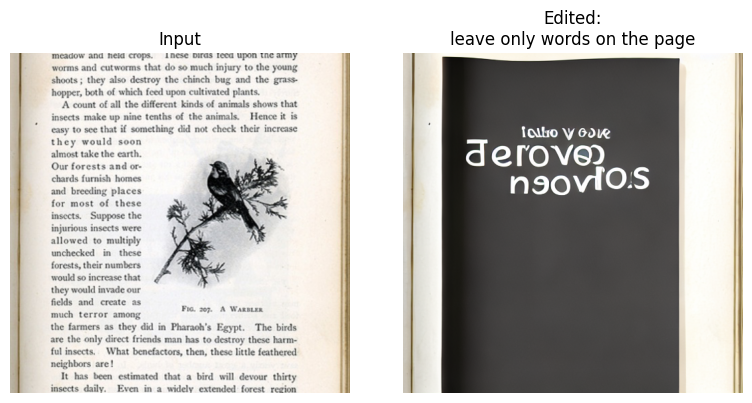

In [ ]:
# Resize input image
input_img = ds[1]["source_img"].resize((512, 512))
prompt = ds[1]["instruction"]

# Run inference
edited = pipe(prompt=prompt, image=input_img, num_inference_steps=50).images[0]

# Display input and result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_img)
plt.title("Input")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edited)
plt.title(f"Edited:\n{prompt}")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def show_triplet(sample):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(sample["source_img"])
    axs[0].set_title("Source")
    axs[0].axis("off")

    axs[1].imshow(sample["mask_img"])
    axs[1].set_title("Mask")
    axs[1].axis("off")

    axs[2].text(0.5, 0.5, sample["instruction"], wrap=True, ha="center", va="center")
    axs[2].set_title("Instruction")
    axs[2].axis("off")

    axs[3].imshow(sample["target_img"])
    axs[3].set_title("Target")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()
def run_edit(sample):
    img = sample["source_img"].resize((512, 512))
    result = pipe(prompt=sample["instruction"], image=img, num_inference_steps=50).images[0]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].set_title("Source")
    axs[0].axis("off")

    axs[1].imshow(result)
    axs[1].set_title("Model Output")
    axs[1].axis("off")

    axs[2].imshow(sample["target_img"])
    axs[2].set_title("Ground Truth")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

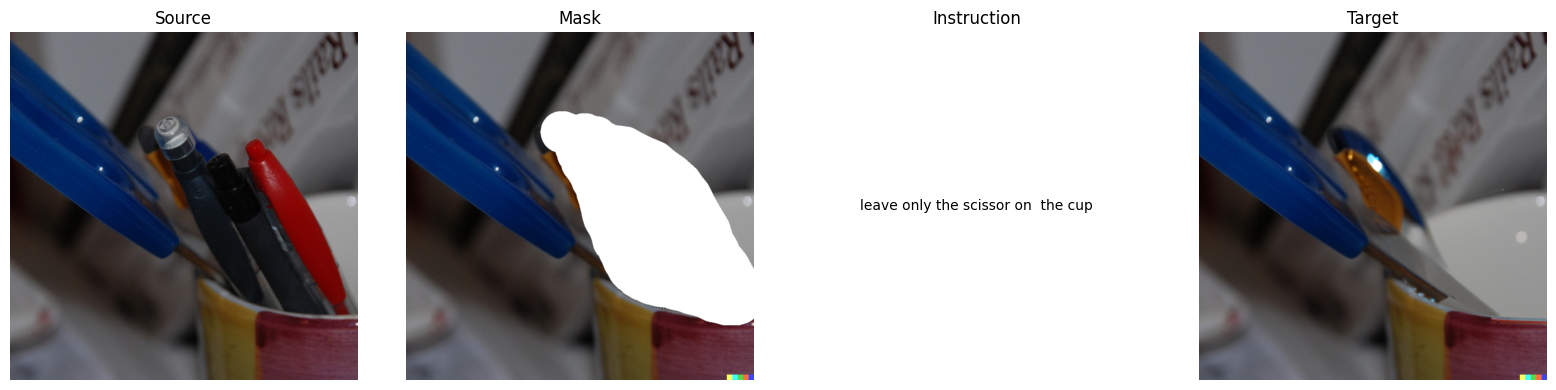

  0%|          | 0/50 [00:00<?, ?it/s]

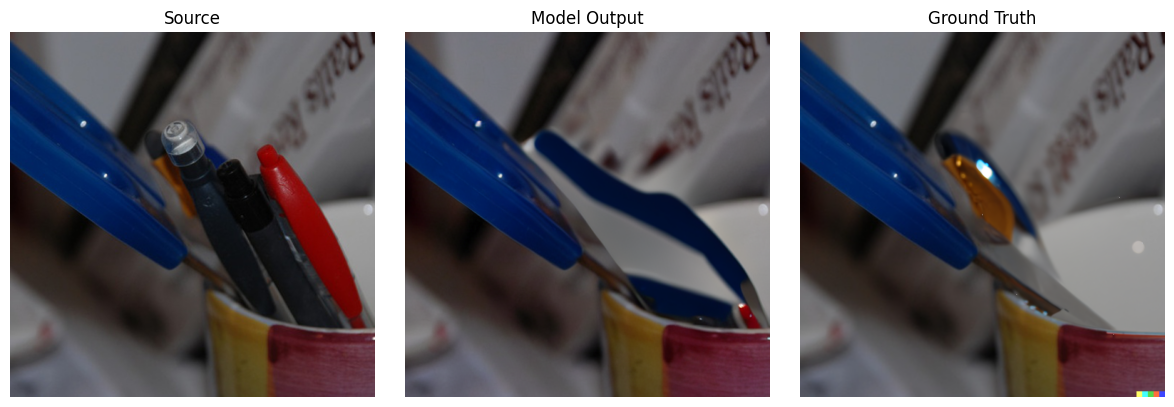

In [ ]:
# Show a triplet and run model edit
show_triplet(ds[3])
run_edit(ds[3])

Trying random stuff below